## Import necessary modules, set up environment

In [40]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgObsWrapper, RGBImgPartialObsWrapper
from stable_baselines3 import PPO
import gymnasium
import cv2

In [3]:
env = gymnasium.make("MiniGrid-LockedRoom-v0")
print(env.observation_space)
env = RGBImgPartialObsWrapper(env)
print(env.observation_space)

Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x179a73d00>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))
Dict('direction': Discrete(4), 'image': Box(0, 255, (56, 56, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x179a73d00>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))


## Set up the wrappers for the environment

`MissionEncodingWrapper` adds one for every discrete space in the one-hot encoding of the mission, allowing 0 to be encoded as well.

`ImageFeaturesExtractor` extracts relevant features if the observation is just an image, used with `ImgObsWrapper`

`MinigridFeaturesExtractor` extracts relevant features from the entire observation, used with `MissionEncodingWrapper` and `DictObservationSpaceWrapper`

In [4]:

from gymnasium import ObservationWrapper
import numpy as np
# a custom wrapper to make the mission vector work with one hot encoding
class MissionEncodingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['mission'] = spaces.MultiDiscrete(np.array([n+1 for n in env.observation_space['mission'].nvec]))
    def observation(self, obs):
        return obs

In [5]:
class ImageFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gymnasium.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [6]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
       
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

### Train the model and save it. -- also try `FlatObsWrapper`

Dict('direction': Discrete(4), 'image': Box(0, 255, (152, 152, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x179a73d00>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))


/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/Users/lucg/.pyenv/versions/3.10.13/envs/6.8200/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you

(608, 608, 3)


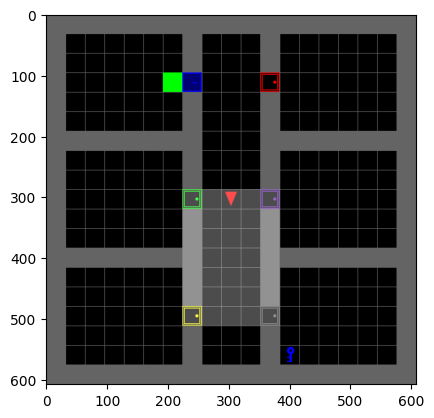

In [7]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
# env = DictObservationSpaceWrapper(env)
# env = MissionEncodingWrapper(env)
env = RGBImgObsWrapper(env)

print(env.observation_space)
env.reset()
r = env.render()
print(r.shape)
plt.imshow(r)

In [8]:
class Actions:
    LEFT = 0
    RIGHT = 1
    FORWARD = 2
    PICKUP = 3
    DROP = 4
    TOGGLE = 5
    DONE = 6

DIRECTION:
Up: 3
Left: 2
Down: 1
Right: 0

### Record Video of the trained policy

## How to render image

-- good for passing into GPT4 VLM

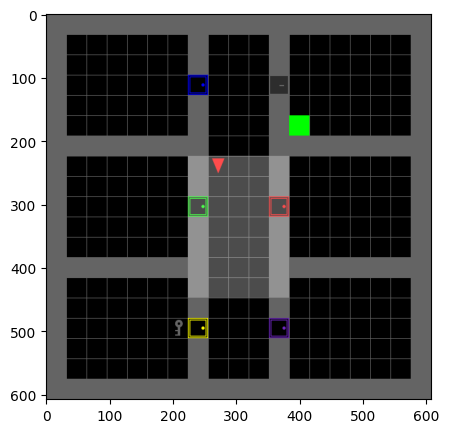

In [9]:
env.reset()
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

## Custom Reward Function

In [10]:
from openai import OpenAI
from api.settings import Settings

openai_client = OpenAI(api_key=Settings().openai_key)

def vision(prompt_text: str, img_base64: str):
    """Run a GPT-4 vision model on the prompt text and image.

    ```
    from PIL import Image
    im = Image.fromarray(r)
    vision("what do you see?", image_to_base64(im))
    ```
    """
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img_base64}",
                        "detail": "low"
                    },
                },
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=600,
    )
    return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=300,
    )
    return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=800,
    )
    return response



## Custom Reward

In [11]:
# custom_parking_env.py
from typing import Callable, List

from gymnasium.envs.registration import register
from minigrid.envs.lockedroom import LockedRoomEnv

from gymnasium import spaces

import numpy as np


class CustomMinigridEnv(LockedRoomEnv):
    def __init__(
        self,
        *args,
        compute_reward: Callable[["CustomMinigridEnv", spaces.Dict], float],
        **kwargs
    ):  
        self.compute_reward_func = compute_reward
        super().__init__(*args, **kwargs)
        
    # this function is useless
    
    # def _reward(self) -> float:
    #     return self.compute_reward_func(current_state)
    
    def get_reward(self, obs):
        return self.compute_reward_func(obs)
    
    def step(self, action):
        obs, _, terminated, truncated, info = super().step(action)
        reward = self.compute_reward_func(obs)
        return obs, reward, terminated, truncated, info

register( id="CustomLockedRoom-v0", entry_point=CustomMinigridEnv)

In [12]:
image_env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array") # filler env to get the render with filler reward
# purposely have alias so that I can change it later
ob, info = image_env.reset()
render = image_env.render()
ob['mission']

'get the red key from the yellow room, unlock the red door and go to the goal'

'get the green key from the yellow room, unlock the green door and go to the goal'

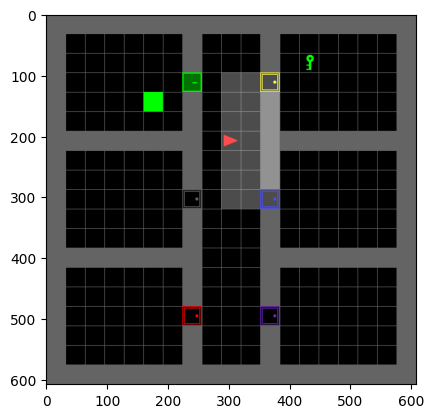

In [13]:
ob, info = image_env.reset()
render = image_env.render()
plt.imshow(render)
ob['mission']

In [14]:
class WithoutMissionExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)


    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return { 'image': observations['image'], 'direction': observations['direction'] }

In [33]:
prompt1 = '''You are an assistant aiding with subgoal generataion for reinforcement learning problems. Specifically, you will
be given an example environment picture and a textual goal description, and you are to output language subgoals that the agent
should achieve in order to efficiently and successfully achieve the main goal.

The goal description is:

“get the {lockedroom_color} key from the {keyroom_color} room, unlock the {door_color} door and go to the goal”

where you can use {lockedroom_color}, {keyroom_color}, and {door_color} as variables in the subgoals and the goal is a light green square.
The variables can be the values “red”, “green”, “blue”, “purple”, “yellow” or “grey”.

These subgoals should be with respect to the image itself:
they should specify specific observations that show that the agent is on track. Output a list of ONLY these text subgoals in the following format (without any introduction text):

- [subgoal 1]
- [subgoal 2]
- ...

where [subgoal i] is replaced by the ith subgoal. You should output 5 (five) subgoals Do not create directional subgoals but rather strategic
subgoals that do not hard code the direction but instead tell the agent which states are more beneficial.

Keep in mind that the included image is an example of the environment but the door, key, and goal locations may differ so use it for context but do not
hardcode the goals with respect to this specific image.
'''

prompt2 = '''
You are an assistant tasked with turning language subgoals into machine readable code. You will be given text subgoals, and you must translate
these subgoals into code that takes in an observation of the format

{'direction': Discrete(4), 'image': np.ndarray, 'mission': str}

where image is of shape (56x56x3), and the final dimension corresponds to RGB colors.
Each 56x56 subarray corresponds to the agent's field of view in pixels, with the agent centered at the bottom of the image.
Furthermore, thedirection corresponds to an enumeration where

Up: 3, Left: 2, Down: 1, Right: 0

and each image observation is centered such that the agent is facing the entire observation and none of the image observation is behind the agent,
and it can only see in front and to the side of itself.

The text subgoals will include variables {lockedroom_color}, {keyroom_color}, and {door_color}, which can take values 
“red”, “green”, “blue”, “purple”, “yellow” or “grey”. These colors may not be precise; make sure to account for some error here.
The 'mission' key in observation is of form

“get the {lockedroom_color} key from the {keyroom_color} room, unlock the {door_color} door and go to the goal”

As part of your reward function, you can use these three variables {lockedroom_color}, {keyroom_color}, and {door_color}
to determine your specific reward function for the sub goal.

The reward function must have parameters: {observation, lockedroom_color, keyroom_color, door_color}.

Output the subgoal as a python function that takes in the above parameters and returns the reward that prioritizes the specific subgoal.
This reward function should be dense; it should make the agent want to move closer to the specific subgoal. Have the maximum reward of the function be 1 (where the goal is obtained) and the minimum be 0.
You can do this by locating the subgoal in the image observation and using a distance metric from the agent to this subgoal location to output a reward based on just that subgoal.
The code should be the only thing you output, all in one python function without sub functions. Name each function `reward_i` where i is ''' # add i

In [34]:
from PIL import Image
from api.image import image_to_base64

im = Image.fromarray(render)
completion1 = vision(prompt1, image_to_base64(im))

In [35]:
print(completion1.choices[0].message.content)

- Locate the {keyroom_color} room containing the key.
- Acquire the {lockedroom_color} key from the {keyroom_color} room.
- Navigate to the {door_color} door using the acquired key.
- Unlock the {door_color} door.
- Proceed to the light green square representing the goal.


In [36]:
im = Image.fromarray(render)
completions = []
for i, sg in enumerate(tqdm(completion1.choices[0].message.content.splitlines())):
    completions.append(complete(prompt2 + str(i) + '\nThe textual subgoal is as follows: ' + sg))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:26<00:00, 29.26s/it]


In [37]:
completion_funcs = [c.choices[0].message.content for c in completions]
completion_funcs_execute = ['\n'.join(c.splitlines()[1:-1]) for c in completion_funcs]
for c in completion_funcs_execute:
    # print(c)
    exec(c)

In [38]:
def mission_to_string(mission_encoding):
    indices = [idx - 1 for idx in mission_encoding] # remove offset
    translation = {v: k for k, v in DictObservationSpaceWrapper.get_minigrid_words().items()}
    translation[-1] = ''
    return ' '.join([translation[idx] for idx in indices])
    

In [39]:
print(completion_funcs_execute[0])

def reward_0(observation, lockedroom_color, keyroom_color, door_color):
    import numpy as np
    
    # Define color ranges for each possible room color
    color_ranges = {
        'red': ((200, 0, 0), (255, 50, 50)),
        'green': ((0, 200, 0), (50, 255, 50)),
        'blue': ((0, 0, 200), (50, 50, 255)),
        'purple': ((128, 0, 128), (192, 70, 192)),
        'yellow': ((200, 200, 0), (255, 255, 50)),
        'grey': ((130, 130, 130), (160, 160, 160))
    }
    
    # Get the color range for the keyroom
    lower_color, upper_color = color_ranges[keyroom_color]
    
    # Convert the color bounds to numpy arrays
    lower_bound = np.array(lower_color, dtype=np.uint8)
    upper_bound = np.array(upper_color, dtype=np.uint8)
    
    # Extract the image from the observation
    image = observation['image']
    
    # Find pixels within the specified color range
    mask = cv2.inRange(image, lower_bound, upper_bound)
    
    # Calculate the center of mass of the detected keyroo

In [52]:
EPSILON = 0.2
def generate_total_reward():
    goal_number = 0
    reward_funcs = [reward_0, reward_1, reward_2, reward_3, reward_4]
    def total_reward(obs):
        nonlocal goal_number
        
        # turn obs back into mission string
        #obs['mission'] = mission_to_string(obs['mission'])
        
        # preprocess -- ideally this would be done with LLM if we had more compute
        lockedroom_color = obs['mission'].split(' ')[2]
        keyroom_color = obs['mission'].split(' ')[6]
        door_color = obs['mission'].split(' ')[10]
        
        reward = reward_funcs[goal_number](obs, lockedroom_color, keyroom_color, door_color)
        # print("current goal number", goal_number)
        # print(f"goal: {goal_number} | reward:{reward}")

        if reward > 1-EPSILON:
            print(f"switching functions from {goal_number} to {goal_number + 1}")
            goal_number += 1
        
        return reward
    
    return total_reward

env = gymnasium.make("CustomLockedRoom-v0", render_mode="rgb_array", compute_reward = generate_total_reward())
env = RGBImgPartialObsWrapper(env) # convert to RGB obs
env = DictObservationSpaceWrapper(env)

env = MissionEncodingWrapper(env)


In [54]:
model = PPO("MultiInputPolicy", env, verbose=1, ent_coef=0.9)
model.learn(2e5)
model.save("minigrid_models/minigrid_custom/8-iterative-subgoals-generalized")

video_env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-8', episode_trigger=lambda e: e % 2 == 0)

obs, info = video_env.reset()
done = False
video_env.start_video_recorder()
steps = 0
while not done and steps <= 50000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = video_env.step(action)
    steps += 1
video_env.close_video_recorder()
video_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 761      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 190         |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004320887 |
|    clip_fraction        | 0.0142      |
|    clip_range      

KeyboardInterrupt: 

In [286]:
env = gymnasium.make("CustomLockedRoom-v0", render_mode = "rgb_array", compute_reward = generate_total_reward())
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)
model = PPO.load("minigrid_models/minigrid_custom/1")
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
